In [1]:
# Install medical imaging and deep learning libraries
!pip install numpy pandas matplotlib opencv-python SimpleITK nibabel tensorflow torch plotly scipy scikit-image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 11.4 MB/s eta 0:00:00


In [2]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import SimpleITK as sitk
import tensorflow as tf
import torch
import torch.nn as nn
import plotly.graph_objects as go
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Concatenate
from tensorflow.keras.models import Model
import cv2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Change directory to the dataset folder
import os
os.chdir('/content/drive/MyDrive/Medical_Imaging_Project')


Mounted at /content/drive


In [4]:
# Unzipping the datasets
#!unzip -q brats20-dataset.zip -d BRATS20
#!unzip -q luna16-dataset.zip -d LUNA16


In [5]:
!ls /content/drive/MyDrive/Medical_Imaging_Project/BRATS20
!ls /content/drive/MyDrive/Medical_Imaging_Project/BRATS20/BraTS2020_TrainingData
!ls /content/drive/MyDrive/Medical_Imaging_Project/BRATS20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001



BraTS2020_TrainingData	BraTS2020_ValidationData
MICCAI_BraTS2020_TrainingData
BraTS20_Training_001_flair.nii	BraTS20_Training_001_t1ce.nii  BraTS20_Training_001_t2.nii
BraTS20_Training_001_seg.nii	BraTS20_Training_001_t1.nii


Voxel sizes: X = 1.0 mm, Y = 1.0 mm, Z = 1.0 mm


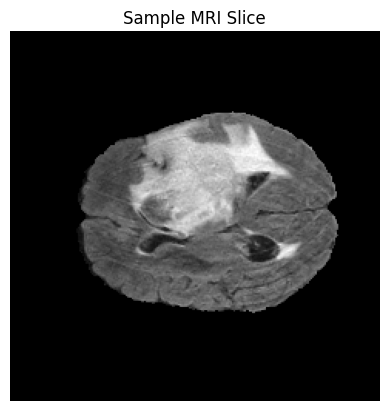

In [6]:
# Load a sample MRI scan from the BRATS dataset
mri_path = '/content/drive/MyDrive/Medical_Imaging_Project/BRATS20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii'
mri_image = nib.load(mri_path)

# Extract voxel dimensions (in mm)
voxel_sizes = mri_image.header.get_zooms()
voxel_size_x, voxel_size_y, voxel_size_z = voxel_sizes[:3]  # First three dimensions
print(f"Voxel sizes: X = {voxel_size_x} mm, Y = {voxel_size_y} mm, Z = {voxel_size_z} mm")

mri_data = mri_image.get_fdata()

# Display a middle slice of the MRI scan
slice_idx = mri_data.shape[2] // 2
plt.imshow(mri_data[:, :, slice_idx], cmap='gray')
plt.title('Sample MRI Slice')
plt.axis('off')
plt.show()


In [7]:
!ls /content/drive/MyDrive/Medical_Imaging_Project/LUNA16/seg-lungs-LUNA16/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd



/content/drive/MyDrive/Medical_Imaging_Project/LUNA16/seg-lungs-LUNA16/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd


CT data shape: (194, 512, 512)


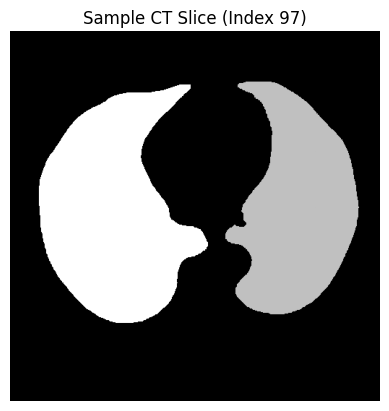

In [8]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

# Path to the .mhd file (the raw data file is located in the same directory with the .zraw extension)
ct_path = '/content/drive/MyDrive/Medical_Imaging_Project/LUNA16/seg-lungs-LUNA16/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd'

# Read the MetaImage (.mhd) file along with the raw data (.zraw)
ct_image = sitk.ReadImage(ct_path)

# Convert the image to a NumPy array for easier manipulation and visualization
ct_data = sitk.GetArrayFromImage(ct_image)

# Print the shape of the image (e.g., (512, 512, num_slices))
print(f"CT data shape: {ct_data.shape}")

# Display a middle slice of the CT scan
slice_idx = ct_data.shape[0] // 2
plt.imshow(ct_data[slice_idx, :, :], cmap='gray')
plt.title(f'Sample CT Slice (Index {slice_idx})')
plt.axis('off')
plt.show()


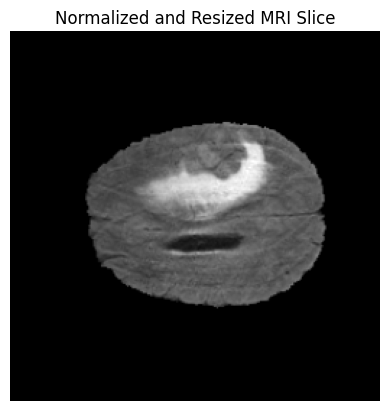

In [9]:
import numpy as np

def normalize_image(image_slice):
    # Avoid division by zero by checking if max and min are equal
    min_val = np.min(image_slice)
    max_val = np.max(image_slice)

    # If max and min are equal, return a slice of zeros or ones
    if max_val == min_val:
        return np.zeros_like(image_slice)  # or np.ones_like(image_slice)

    # Otherwise, normalize the image slice
    return (image_slice - min_val) / (max_val - min_val)


# Example: Normalize and resize an MRI slice
normalized_slice = normalize_image(mri_data[:, :, slice_idx])
resized_slice = cv2.resize(normalized_slice, (256, 256))

plt.imshow(resized_slice, cmap='gray')
plt.title('Normalized and Resized MRI Slice')
plt.axis('off')
plt.show()


In [10]:
# Stack normalized 2D slices to create a 3D volume
volume_data = np.stack([normalize_image(mri_data[:, :, i]) for i in range(mri_data.shape[2])], axis=-1)
print(f"Reconstructed 3D volume shape: {volume_data.shape}")


Reconstructed 3D volume shape: (240, 240, 155)


In [11]:
#!pip install pyvista

In [12]:
import plotly.graph_objects as go
import numpy as np

# Assuming volume_data is your full 3D volume (e.g., from MRI or CT scan)

# Subsample the volume to reduce its size for visualization (downsampling every 3rd voxel)
downsampled_data = volume_data[::3, ::3, ::3]  # Taking every 3rd voxel

# Create a meshgrid for the subsampled volume
x, y, z = np.indices(downsampled_data.shape)

# Create a 3D scatter plot for the subsampled volume
fig = go.Figure(data=go.Volume(
    x=x.flatten(),
    y=y.flatten(),
    z=z.flatten(),
    value=downsampled_data.flatten(),
    isomin=downsampled_data.min(),
    isomax=downsampled_data.max(),
    opacity=0.1,  # Adjust opacity for better visibility
    surface_count=20  # Number of contour surfaces (adjust for performance)
))

# Set title and labels
fig.update_layout(title="3D Visualization of MRI/CT Volume (Downsampled)", scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z',
))

# Show the plot
fig.show()

In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │         246,017 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264,833 (1.01 MB)

 Trainable params: 264,833 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Assuming you have volume_data (3D numpy array) for MRI data
X_train = []

# For each slice in the volume, normalize and resize
for i in range(volume_data.shape[2]):
    slice_data = volume_data[:, :, i]  # Get each slice
    normalized_slice = normalize_image(slice_data)  # Normalize the slice
    resized_slice = cv2.resize(normalized_slice, (256, 256))  # Resize to 256x256

    # Add the slice to the training data (add an extra dimension for channel)
    X_train.append(resized_slice.reshape(256, 256, 1))

X_train = np.array(X_train)  # Convert list to numpy array
X_train = X_train.astype(np.float32)  # Ensure the correct dtype
# Example: Generate random binary labels for the slices
y_train = np.random.randint(0, 2, X_train.shape[0])  # 0 or 1 labels


In [29]:
print(X_train.shape)


(155, 256, 256, 1)


Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9609 - loss: 0.0431 - val_accuracy: 0.6774 - val_loss: 1.7921
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9900 - loss: 0.0304 - val_accuracy: 0.6774 - val_loss: 1.7928
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9925 - loss: 0.0086 - val_accuracy: 0.6774 - val_loss: 1.8004
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9898 - loss: 0.0253 - val_accuracy: 0.6774 - val_loss: 1.7898
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9933 - loss: 0.0161 - val_accuracy: 0.6774 - val_loss: 1.8026
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9840 - loss: 0.0187 - val_accuracy: 0.6774 - val_loss: 1.8117
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9797 - loss: 0.0142 - val_accuracy: 0.6774 - val_loss: 1.8134
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9929 - loss: 0.0257 - val_accuracy: 0.6774 - v

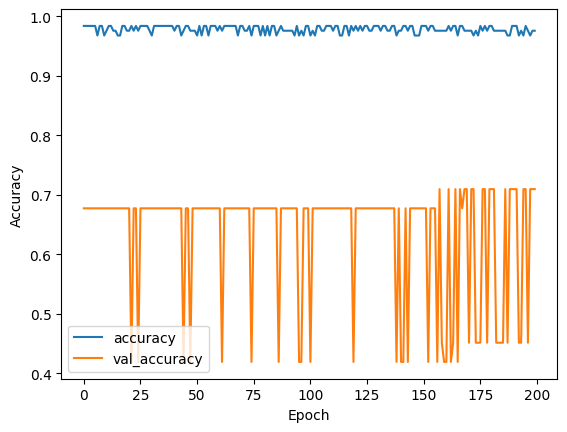

In [37]:
# Assuming X_train is a 4D array with shape (num_samples, height, width, depth, channels)
# y_train should be the corresponding labels (0 or 1 for tumor/non-tumor)


history = model.fit(X_train, y_train, epochs=200, batch_size=2, validation_split=0.2)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [38]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Generate predictions on the training or validation set
y_pred = (predictions > 0.5).astype(int)

# Calculate classification metrics
print("Classification Report:")
print(classification_report(y_train, y_pred, target_names=['No Tumor', 'Tumor']))

# Confusion Matrix
cm = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate accuracy
accuracy = accuracy_score(y_train, y_pred)
print(f"Training Accuracy: {accuracy * 100:.2f}%")


Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.50      0.31      0.39        86
       Tumor       0.42      0.61      0.49        69

    accuracy                           0.45       155
   macro avg       0.46      0.46      0.44       155
weighted avg       0.46      0.45      0.43       155

Confusion Matrix:
[[27 59]
 [27 42]]
Training Accuracy: 44.52%


In [39]:
import numpy as np
from scipy.ndimage import label

# Binary thresholding to isolate tumor voxels
tumor_voxels = volume_data > 0.5

# Label connected components
labeled_array, num_features = label(tumor_voxels)

# Find the largest connected component (assumed to be the tumor)
largest_component = (labeled_array == np.argmax(np.bincount(labeled_array.flat)[1:]) + 1)

# Calculate depth (z-axis spread)
z_indices = np.where(largest_component)[2]
tumor_depth = (np.max(z_indices) - np.min(z_indices) + 1) * voxel_size_z
print(f"Tumor Depth: {tumor_depth:.2f} mm")

# Refine binary mask using intensity weighting
weighted_voxels = np.clip(volume_data, 0, 1)  # Clamp values between 0 and 1

# Calculate the total volume
voxel_volume = voxel_size_x * voxel_size_y * voxel_size_z
tumor_volume = np.sum(weighted_voxels) * voxel_volume
print(f"Tumor Volume: {tumor_volume:.2f} mm³")


Tumor Depth: 135.00 mm
Tumor Volume: 618341.56 mm³


In [40]:
from scipy.spatial import ConvexHull

# Extract 3D coordinates of tumor voxels
tumor_coords = np.column_stack(np.where(tumor_voxels))

# Calculate the convex hull
hull = ConvexHull(tumor_coords)

# Tumor spread along principal axes
x_spread = (np.max(tumor_coords[:, 0]) - np.min(tumor_coords[:, 0])) * voxel_size_x
y_spread = (np.max(tumor_coords[:, 1]) - np.min(tumor_coords[:, 1])) * voxel_size_y
z_spread = (np.max(tumor_coords[:, 2]) - np.min(tumor_coords[:, 2])) * voxel_size_z
print(f"Tumor Spread (Convex Hull):")
print(f"  X-axis: {x_spread:.2f} mm")
print(f"  Y-axis: {y_spread:.2f} mm")
print(f"  Z-axis: {z_spread:.2f} mm")


Tumor Spread (Convex Hull):
  X-axis: 134.00 mm
  Y-axis: 155.00 mm
  Z-axis: 134.00 mm


In [41]:
from skimage.morphology import skeletonize_3d

# Skeletonize the largest component
skeleton = skeletonize_3d(largest_component)

# Compute the center of the skeleton (geometric center of non-zero voxels)
skeleton_coords = np.column_stack(np.where(skeleton))
skeleton_center = skeleton_coords.mean(axis=0)

# Convert voxel indices to physical coordinates
skeleton_center_coords = [
    skeleton_center[0] * voxel_size_x,
    skeleton_center[1] * voxel_size_y,
    skeleton_center[2] * voxel_size_z,
]
print(f"Tumor Center of Mass (Medial Axis):")
print(f"  X: {skeleton_center_coords[0]:.2f} mm")
print(f"  Y: {skeleton_center_coords[1]:.2f} mm")
print(f"  Z: {skeleton_center_coords[2]:.2f} mm")


<ipython-input-41-6baf7981d6a1>:4: FutureWarning:

`skeletonize_3d` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.morphology.skeletonize` instead.



Tumor Center of Mass (Medial Axis):
  X: 112.99 mm
  Y: 135.71 mm
  Z: 87.50 mm


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predictions shape: (155, 1)
Sample 1 - Predicted Label: No Tumor
Sample 2 - Predicted Label: No Tumor
Sample 3 - Predicted Label: No Tumor
Sample 4 - Predicted Label: No Tumor
Sample 5 - Predicted Label: Tumor


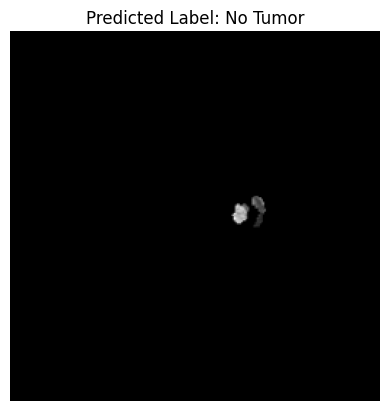

In [42]:
import matplotlib.pyplot as plt

# Get predictions from the model
predictions = model.predict(X_train)
print("Predictions shape:", predictions.shape)

# Assuming `predictions` is of shape (num_samples, 1) because of the binary classification output
# For visualization, let's just print the prediction value for each sample
for i in range(5):  # Display the first 5 predictions
    print(f"Sample {i+1} - Predicted Label: {'Tumor' if predictions[i] > 0.5 else 'No Tumor'}")

# If you want to plot a random input image along with its prediction:
sample_idx = 7 # Choose a sample index
plt.imshow(X_train[sample_idx].reshape(256, 256), cmap='gray')
plt.title(f"Predicted Label: {'Tumor' if predictions[sample_idx] > 0.5 else 'No Tumor'}")
plt.axis('off')
plt.show()


In [44]:
# Save the trained model in the newer Keras format
model.save('tumor_detection_model.keras')

# Download the model file
#from google.colab import files
#files.download('tumor_detection_model.keras')


Saving mri1.jpg to mri1 (6).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
Prediction: Tumor detected.


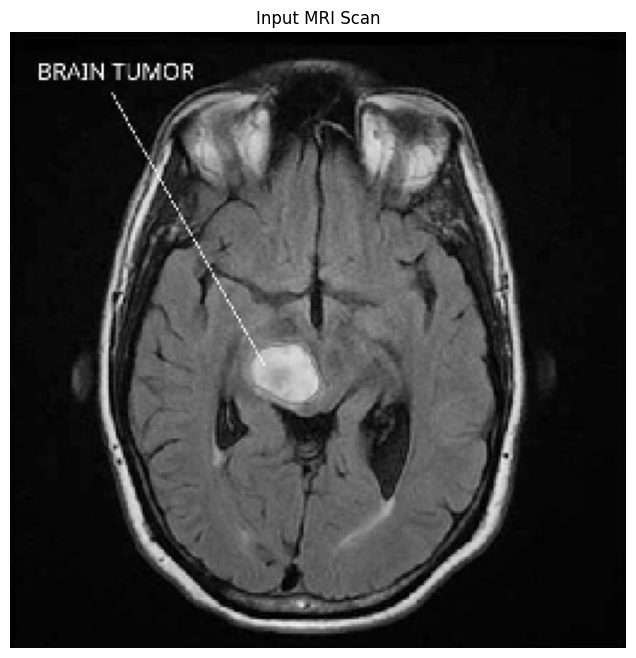

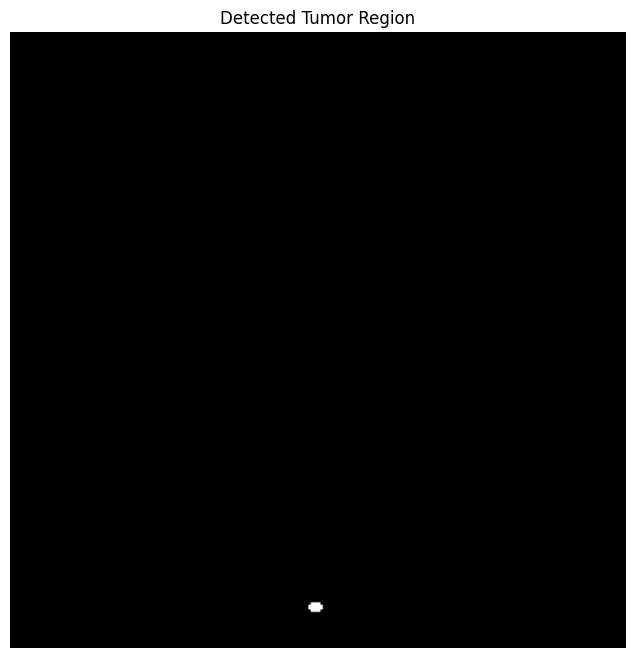

Tumor Analysis:
  Tumor Area: 4745.00 mm²
  Tumor Bounding Box: x=125, y=238, width=3, height=1
  Approx. Center of Tumor: (126, 238)


In [49]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.models import load_model
import cv2

# Load the trained model
model_path = "/content/drive/My Drive/tumor_detection_model (5).keras"  # Update this with your model path
model = load_model(model_path)

# Define the expected input image dimensions for your model
img_height, img_width = 256, 256  # Update if your model expects different dimensions

# Upload an MRI scan from your local system
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload an image

# Get the file path of the uploaded image
image_path = list(uploaded.keys())[0]  # The name of the uploaded file

# Load and preprocess the image
img = load_img(image_path, target_size=(img_height, img_width))  # Resize image to model input size
img_array = img_to_array(img)  # Convert to NumPy array

# Check and ensure the image is grayscale (1 channel)
if img_array.shape[-1] == 3:  # If the image has 3 channels (RGB)
    img_array = cv2.cvtColor(img_array.astype('uint8'), cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    img_array = np.expand_dims(img_array, axis=-1)  # Add the channel dimension back

# Normalize the image data to the range [0, 1]
img_array = img_array / 255.0

# Add a batch dimension to the image array
img_array = np.expand_dims(img_array, axis=0)  # Shape becomes (1, height, width, channels)

# Make predictions using the model
prediction = model.predict(img_array)

# Interpret the prediction
if prediction[0] > 0.5:
    tumor_detected = True
    print("Prediction: Tumor detected.")
else:
    tumor_detected = False
    print("Prediction: No tumor detected.")

# Tumor Analysis (if a tumor is detected)
if tumor_detected:
    # Visualize the original grayscale image
    img_grayscale = img_array[0].reshape(img_height, img_width)  # Remove batch and channel dimensions
    plt.figure(figsize=(8, 8))
    plt.imshow(img_grayscale, cmap='gray')
    plt.title("Input MRI Scan")
    plt.axis("off")
    plt.show()

    # Apply a threshold to highlight tumor regions
    threshold_value = 0.5  # Adjust based on your model's confidence range
    tumor_mask = (img_grayscale > threshold_value).astype(np.uint8)

    # Calculate tumor metrics
    tumor_area = np.sum(tumor_mask)  # Number of tumor pixels
    pixel_area = 1.0  # Assume each pixel represents 1 mm² (update with real-world voxel dimensions)
    tumor_area_mm2 = tumor_area * pixel_area

    # Calculate bounding box around the tumor
    contours, _ = cv2.findContours(tumor_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])  # Bounding box of the largest contour

        # Visualize the tumor region
        plt.figure(figsize=(8, 8))
        tumor_region = cv2.rectangle(img_grayscale.copy(), (x, y), (x + w, y + h), (255, 0, 0), 2)
        plt.imshow(tumor_region, cmap='gray')
        plt.title("Detected Tumor Region")
        plt.axis("off")
        plt.show()

        # Print tumor metrics
        print("Tumor Analysis:")
        print(f"  Tumor Area: {tumor_area_mm2:.2f} mm²")
        print(f"  Tumor Bounding Box: x={x}, y={y}, width={w}, height={h}")
        print(f"  Approx. Center of Tumor: ({x + w//2}, {y + h//2})")
else:
    print("No further analysis as no tumor was detected.")
